In [ ]:
from scipy.spatial import Voronoi

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["figure.dpi"] = 150

import pandas as pd
import os

import vis.Visualization as visual
import vis.CommunityWise as cwise
import vis.Utils as utils

from datetime import datetime

import networkx as nx
import community as community_louvain

In [53]:
# These are the folders where we'll find the grids or community lists
gridFolder = 'grids'
communityFolder = 'communities'

# This is the number of community detections to perform in the last step
numCommunityDetections = 3

# I will assume there a few values of the parameter that give reasonable results,
# and we will onyl sample those
goodParameterValues = ['0.80', '0.90']

pointArr, communityArr = utils.loadCommunityData(gridFolder, communityFolder, goodParameterValues)

# Select just a few communities to average over for testing
goodCommunities = np.arange(3) #[0, 3, 6, 9]
pointArr = np.array(pointArr, dtype='object')[goodCommunities]
communityArr = np.array(communityArr, dtype='object')[goodCommunities]

# Generate some colors to use for each set of communities
randomColors = [visual.genRandomColors(max(communityArr[i]), 20) for i in range(len(goodCommunities))]

Misalignment or invalid communities: DM11G0.80.csv
Misalignment or invalid communities: DM11G0.90.csv


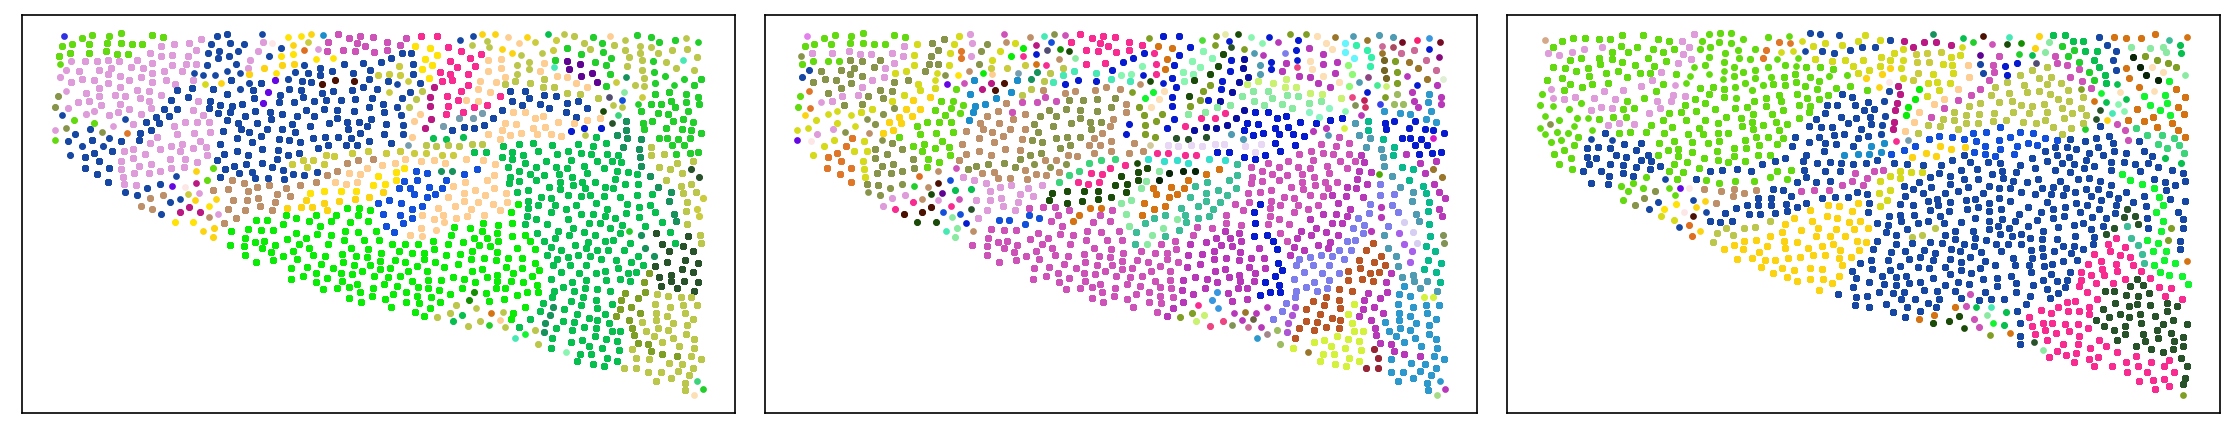

In [50]:
fig, ax = plt.subplots(1, len(communityArr), figsize=(len(communityArr)*5, 3))

for i in range(len(communityArr)):
    visual.drawPoints(ax[i], pointArr[i], communityArr[i], randomColors[i], s=5)
fig.tight_layout()
plt.show()

In [22]:
# Now we create a uniform grid
gridPoints = 50

# Not exactly the most efficient method to find the extreme points across
# all configurations, but it works well enough
flattenedX = []
flattenedY = []

for i in range(len(communityArr)):
    for j in range(len(pointArr[i])):
        flattenedX.append(pointArr[i][j,0])
        flattenedY.append(pointArr[i][j,1])

uniformX = np.linspace(min(flattenedX), max(flattenedX), gridPoints)
uniformY = np.linspace(min(flattenedY), max(flattenedY), gridPoints)

uniformGridPoints = np.zeros([gridPoints, gridPoints, 2])

for i in range(gridPoints):
    for j in range(gridPoints):
        uniformGridPoints[i,j] = [uniformX[i], uniformY[j]]
        
uniformGridPoints = uniformGridPoints.reshape([gridPoints*gridPoints, 2])

In [40]:
# Normalize the node points for each one
hullLines = []
communityBoundaries = []

uniformPointArr = []
uniformCommunityArr = []

for i in range(len(communityArr)):
    # Calculate the boundaries for each detection
    # NOTE: This may take a while, about 1-2 minutes per detection for 50 gridPoints
    currVor = Voronoi(pointArr[i])
    currHullLines, currHullLineCommunities = cwise.concaveHull(pointArr[i], communityArr[i])
    currCommunityBoundaries = cwise.vorToCommunityBounds(currVor, communityArr[i], currHullLines, currHullLineCommunities)
    
    # Make sure that there aren't any weird things going on with this detection
    # Sometimes you will get artifacts of something (idk what) so we just throw those away\
    badDetection = False
    for j in range(len(currCommunityBoundaries)):
        if len(currCommunityBoundaries[j]) == 0:
            badDetection = True
            break
    if badDetection:
        print(f'Warning: bad detection at index {i}')
        continue
        
    currUniformPoints, currUniformCommunities = cwise.assignCommunities(uniformGridPoints, currCommunityBoundaries, currHullLines)
    
    # And save some things
    hullLines.append(currHullLines)
    communityBoundaries.append(currCommunityBoundaries)
    uniformPointArr.append(currUniformPoints)
    uniformCommunityArr.append(currUniformCommunities)

# We also have to make sure that each uniform set of points
# is exactly the same, since the slight variations in boundary sizes
# could make a difference
pointCounts = [len(uniformPointArr[i]) for i in range(len(uniformPointArr))]
if len(np.unique(pointCounts)) > 1:
    # For each point, make sure it exists in the other lists
    for i in range(len(uniformPointArr)):
        # Count backwards here, so we can remove
        for j in range(len(uniformPointArr[i])-1, -1, -1):
            if False in [uniformPointArr[i][j] in uniformPointArr[k] for k in range(len(uniformPointArr))]:
                del uniformPointArr[i][j]

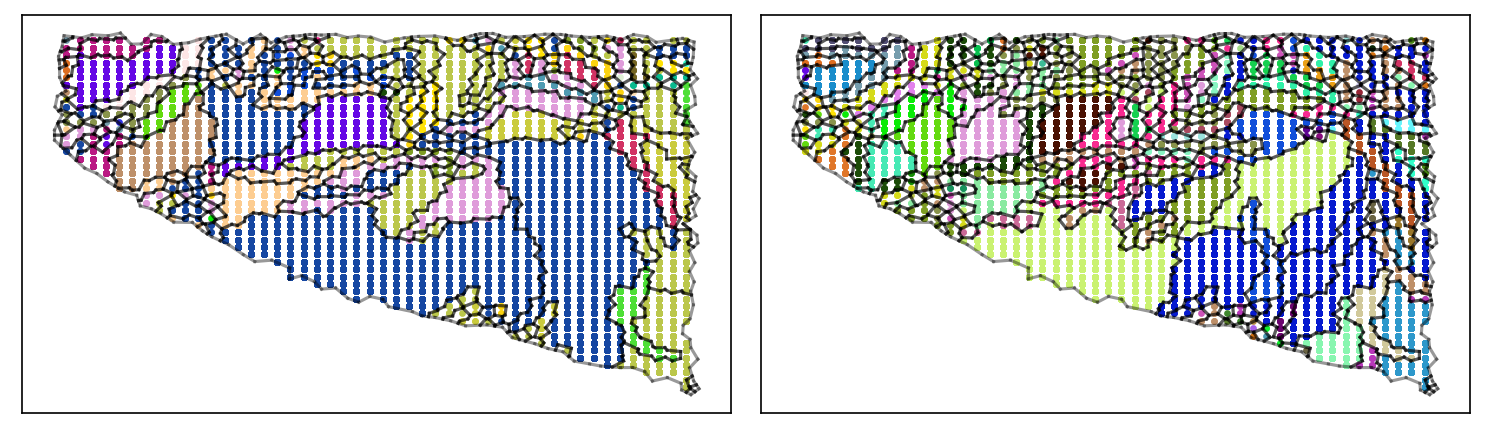

In [49]:
fig, ax = plt.subplots(1, len(uniformCommunityArr), figsize=(len(uniformCommunityArr)*5, 3))

for i in range(len(uniformCommunityArr)):
    visual.drawPoints(ax[i], uniformPointArr[i], uniformCommunityArr[i], randomColors[i], s=5)
    for j in range(len(communityBoundaries[i])):
        visual.drawLines(ax[i], communityBoundaries[i][j], opacity=.4)
fig.tight_layout()
plt.show()

In [61]:
consensusMatrix = cwise.calculateConsensusMatrix(uniformCommunityArr)

# plt.pcolor(consensusMatrix)
# plt.colorbar()
# plt.show()

# Now we can create a graph from the consensus matrix
graph = nx.from_numpy_matrix(consensusMatrix)
finalPoints = uniformPointArr[0]

partitionArr = []
genlouvainResolutions = np.random.normal(.75, .05, size=[3])
for i in range(numCommunityDetections):
    # Perform the community detection
    currPartition = community_louvain.best_partition(graph, resolution=genlouvainResolutions[i], randomize=True)
    currPartition = list(currPartition.values())
    currPartition = cwise.patchCommunityIndices(currPartition)
    partitionArr.append(currPartition)

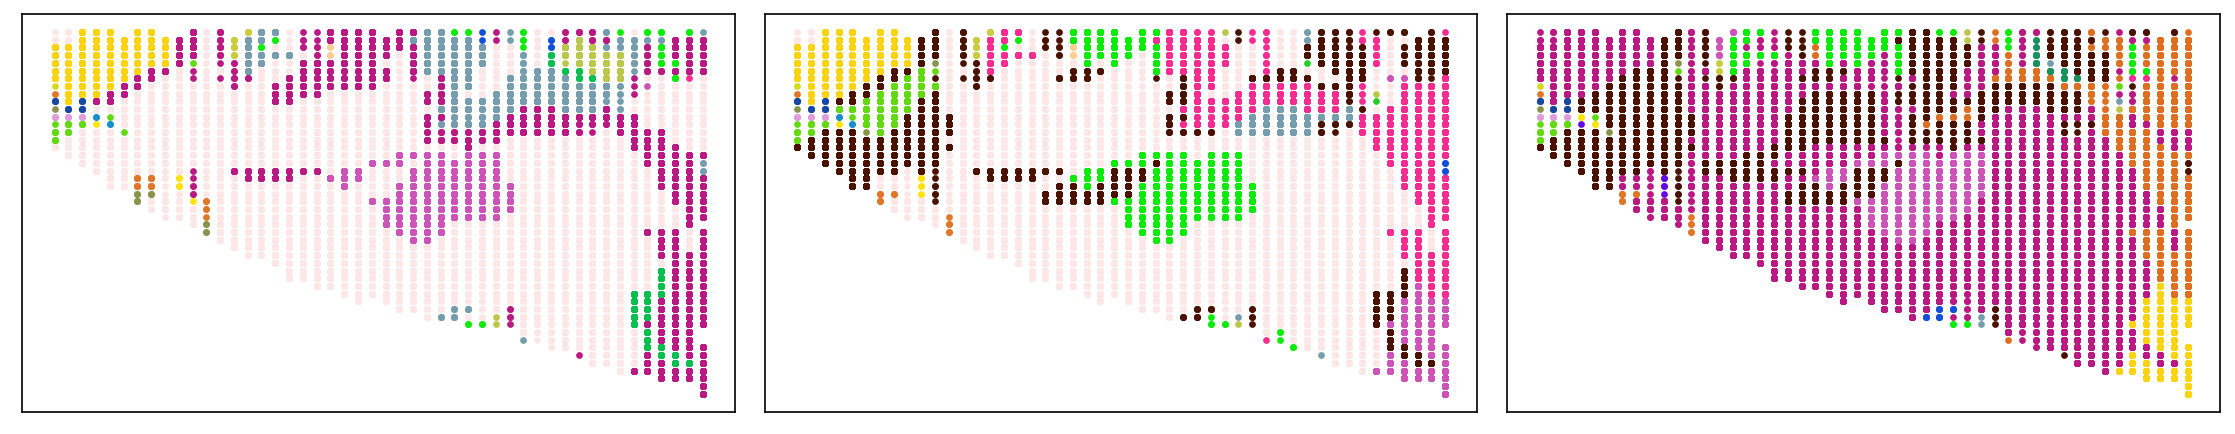

In [62]:
fig, ax = plt.subplots(1, len(partitionArr), figsize=(len(partitionArr)*5, 3))

finalRandomColors = [visual.genRandomColors(max(partitionArr[i])) for i in range(len(partitionArr))]

for i in range(len(partitionArr)):
    visual.drawPoints(ax[i], finalPoints, partitionArr[i], randomColors[i], s=5)
fig.tight_layout()
plt.show()